In [3]:
%load_ext autoreload
%autoreload 2
    
from DarkMatter import *
from scipy.interpolate import interp1d

Welcome to JupyROOT 6.26/08


## Step 1: Generate fake PSF (e.g., 10 TeV)

In [ ]:
dwarf = "ursa_minor"
en = 10000

irf = ResponseFunction.VEGAS.readIRFs(dwarf)
PSF = irf.PSF

In [ ]:
gPSF1D = JProfile.getPSF1D(PSF, en, package="VEGAS")
vts = JProfile.getPSFcont(gPSF1D)
int_vts = interp1d(vts[1], vts[0])
angres_vts = int_vts(0.6827)

gPSF1D_fake = ResponseFunction.fakePSF(0.02)
fake = JProfile.getPSFcont(gPSF1D_fake)
int_fake = interp1d(fake[1], fake[0])
angres_fake = int_fake(0.6827)

In [ ]:
etc = plt.plot(*vts, label="VERITAS PSF ({:.0f} TeV)".format(en/1000))
plt.axvline(angres_vts, color=etc[0].get_color(), ls="--", label="68%={:.2f}".format(angres_vts))

etc = plt.plot(*fake, label="Fake PSF (Gaussian)")
plt.axvline(angres_fake, color=etc[0].get_color(), ls="--", label="68%={:.2f}".format(angres_fake))

plt.axhline(0.68, color="k", ls="--")
plt.xlabel("Theta [deg]", fontsize=15)
plt.ylabel("PSF containment", fontsize=15)
plt.legend(fontsize=13)
plt.grid()
plt.xlim(0, 0.5)

## Step 2: Convolve with a J profile

In [ ]:
gJProf = JProfile.calcJProfile(dwarf, seed=defaultNum[dwarf])

In [ ]:
J_vts, e = JProfile.calcHKConvJProf2D(gJProf, gPSF1D, package="VEGAS")
J_fake, e = JProfile.calcHKConvJProf2D(gJProf, gPSF1D_fake, package="VEGAS")
jProfile_fake = interp1d([10, 1e8], [J_fake, J_fake])

print("Convolved J profile")
print("VERITAS: {:.3e}".format(J_vts))
print("Fake: {:.3e}".format(J_fake))
print("Ratio: {:.2f}".format(J_fake/J_vts))

In [ ]:
jProfile_vts = JProfile.generateConvolvedJ(dwarf, package="VEGAS",  seed=defaultNum[dwarf], return_array=True, save_root=False)

In [ ]:
fake_j = []
theta = [0.2, 0.15,  0.1, 0.08, 0.05, ]
for th in theta :
    gPSF1D_fake = ResponseFunction.fakePSF(th)
    J_fake, e = JProfile.calcHKConvJProf2D(gJProf, gPSF1D_fake, package="VEGAS")
    fake_j.append(J_fake)

In [ ]:
plt.plot(theta, fake_j)
plt.grid()
plt.yscale("log")
plt.xlim(0, 0.11)
plt.xlabel("Angular resolution (68%) [deg]", fontsize=13)
plt.ylabel(r"Convolved J profile [GeV$^2$cm$^{-5}$]", fontsize=13)

In [ ]:
c = ["#74a9cf", "#3690c0", "#0570b0",  "#034e7b", "blue"]
for i, p in enumerate(theta):
    plt.plot(jProfile_vts[0][:,0]/1e3, np.ones(len(jProfile_vts[0][:,0]))*fake_j[i], color=c[i], label="PSF$_{{68\%}}$={:.2f}$^\circ$".format(p))
    
plt.plot(jProfile_vts[0][:,0]/1e3, jProfile_vts[0][:,1], label="VERITAS", color="r")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Energy [TeV]", fontsize=13)
plt.ylabel(r"Convolved J profile [GeV$^2$cm$^{-5}$]", fontsize=13)
plt.legend(fontsize=13, ncol=2, loc=3)
#plt.ylim(1e18, 5e18)
plt.xlim(8, 100)
plt.grid(which="both")

## Step 3: Generate EA and Bias

In [ ]:
newirf = ResponseFunction.newirf("VEGAS")
newirf.EA = ResponseFunction.fakeEA(4e5, benchmark="VEGAS")
x, EA_vts = getArray(irf.EA)
x2, EA_fake = getArray(newirf.EA)
plt.plot(10**x, EA_vts, label="VERITAS")
plt.plot(10**x2, EA_fake, label="Fake")
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.legend(fontsize=13)
plt.xlabel("Energy [TeV]", fontsize=15)
plt.ylabel(r"Effective Area [m$^2$]", fontsize=15)
plt.ylim(2000,)

In [ ]:
newirf.Bias = ResponseFunction.fakeBias(0.08, benchmark="VEGAS")
newirf.Bias.SetTitle("Energy Migration (Ideal)")
plotRoot(newirf.Bias)

## Step 4: Get a signal distribution

In [ ]:
newirf.exposure = irf.exposure

In [ ]:
# 1 TeV
sig_fake = Likelihood.calcSignal(dwarf, 1000, newirf, jArray=True,  jProfile=jProfile_fake)
sig_vts = Likelihood.calcSignal(dwarf, 1000, irf, jArray=True, jProfile=jProfile_vts)
plotRoot(sig_fake, sig_vts, logx=True)

In [ ]:
# 10 TeV 
sig_fake = Likelihood.calcSignal(dwarf, 10000, newirf, jArray=True, jProfile=jProfile_fake)
sig_vts = Likelihood.calcSignal(dwarf, 10000, irf, jArray=True, jProfile=jProfile_vts)
plotRoot(sig_fake, sig_vts, logx=True)

In [ ]:
# 100 TeV
sig_fake = Likelihood.calcSignal(dwarf, 100000, newirf, jArray=True, jProfile=jProfile_fake)
sig_vts = Likelihood.calcSignal(dwarf, 100000, irf, jArray=True, jProfile=jProfile_vts)
plotRoot(sig_fake, sig_vts, logx=True)

### Step 4-1: Add cutoff in EA

In [ ]:
newirf.EA = ResponseFunction.fakeEA(4e5, low_cutoff=0.55, s=1.1, benchmark="VEGAS")

In [ ]:
plt.plot(*getArray(newirf.EA), label="Fake", ls="--")
plt.plot(*getArray(irf.EA), label="VERITAS")

plt.yscale("log")
plt.ylim(2000, 2e6)
plt.xlabel("log$_{10}$ Energy [TeV]", fontsize=15)
plt.ylabel("Effective area [m$^2$]", fontsize=15)
plt.legend(fontsize=12)
plt.grid()

In [ ]:
# 10 TeV 
sig_fake = Likelihood.calcSignal(dwarf, 10000, newirf, jArray=True, jProfile=jProfile_fake)
sig_vts = Likelihood.calcSignal(dwarf, 10000, irf, jArray=True, jProfile=jProfile_vts)
print("Total counts: ", sum(getArray(sig_vts)[1]), sum(getArray(sig_fake)[1]))
plotRoot(sig_fake, sig_vts, logx=True)

In [ ]:
# 100 TeV 
sig_fake = Likelihood.calcSignal(dwarf, 100000, newirf, jArray=True, jProfile=jProfile_fake)
sig_vts = Likelihood.calcSignal(dwarf, 100000, irf, jArray=True, jProfile=jProfile_vts)
print("Total counts: ", sum(getArray(sig_vts)[1]), sum(getArray(sig_fake)[1]))
plotRoot(sig_fake, sig_vts, logx=True)

## Step 5: Compare counts at VHE and UHE

In [ ]:
E = np.logspace(2.5, 6, 10)
cnts = []
for en in tqdm(E):
    sig_fake = Likelihood.calcSignal(dwarf, en, newirf, jArray=True, jProfile=jProfile_fake)
    sig_vts = Likelihood.calcSignal(dwarf, en, irf, jArray=True, jProfile=jProfile_vts)
    sig_fake_hdm = Likelihood.calcSignal(dwarf, en, newirf, jArray=True, jProfile=jProfile_fake, DM_spectra="HDM")
    sig_vts_hdm = Likelihood.calcSignal(dwarf, en, irf, jArray=True, jProfile=jProfile_vts, DM_spectra="HDM")
    cnts.append([sum(getArray(sig_vts)[1]), sum(getArray(sig_fake)[1]), sum(getArray(sig_vts_hdm)[1]), sum(getArray(sig_fake_hdm)[1])])
cnts = np.asarray(cnts)

In [ ]:
f, ax = plt.subplots(3,1, figsize=(7, 7), gridspec_kw={'height_ratios':[5,1,1]})
etc = ax[0].plot(E/1e3, cnts[:,0], label="VERITAS (PPPC)")
ax[0].plot(E/1e3, cnts[:,1], label="Fake (PPPC)", color=etc[0].get_color(), ls="--")
etc2 = ax[0].plot(E/1e3, cnts[:,2], label="VERITAS (HDM)")
ax[0].plot(E/1e3, cnts[:,3], label="Fake (HDM)", color=etc2[0].get_color(), ls="--")
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].grid()
ax[0].set_ylabel("Counts", fontsize=15)
ax[0].legend(fontsize=13)
ax[0].set_xlim(0.2, 2e3)

ax[1].plot(E/1e3, cnts[:,0]/cnts[:,1], color=etc[0].get_color(), label="PPPC")
ax[1].plot(E/1e3, cnts[:,2]/cnts[:,3], color=etc2[0].get_color(), label="HDM")
ax[1].set_xscale("log")
ax[1].set_ylim(0.1, 2)
ax[1].grid()
ax[1].set_ylabel("Ratio", fontsize=15)
ax[1].legend(fontsize=12, frameon=False)
ax[1].set_xlim(0.2, 2e3)

ax[2].plot(E/1e3, cnts[:,0]/cnts[:,2], color="k", label="VERITAS")
ax[2].plot(E/1e3, cnts[:,1]/cnts[:,3], color="k", ls="--", label="Fake")
ax[2].set_xscale("log")
ax[2].set_xlabel("DM Mass [TeV]", fontsize=15)
ax[2].set_ylim(0.1, 2)
ax[2].grid()
ax[2].set_ylabel("Ratio", fontsize=15)
ax[2].legend(fontsize=12, frameon=False)
ax[2].set_xlim(0.2, 2e3)

### Step 5.1: with CTA effective area

In [ ]:
EA = [[39.432182, 1.3815514],
[44.520336, 8.865806],
[83.476776, 72.7264],
[141.71916, 300.02066],
[282.70816, 1516.2206],
[421.37457, 3409.6685],
[715.7195, 8153.1963],
[1234.7367, 15931.808],
[2265.9258, 22543.19],
[3457.7178, 30600.43],
[6906.092, 39160.16],
[14671.542, 40145.27],
[28859.38, 45507.008],
[44389.46, 46558.973],
[68290.3, 38144.926]]


In [ ]:
EA = np.asarray(EA)

In [ ]:
EA[:,0] = np.log10(EA[:,0])

In [ ]:
EA[:,0] = EA[:,0]-3

In [ ]:
np.save("HAWC_EA", EA)

In [ ]:
CTA_N = np.load("./temp/CTA_North_50h_EA.npy")

HAWC = np.load("./temp/HAWC_EA.npy")

irf = ResponseFunction.VEGAS.readIRFs("segue_1")
#newirf.EA = ResponseFunction.fakeEA(1e6, benchmark="VEGAS", low_cutoff=0.4, s=1.2)

In [ ]:
x, y = getArray(irf.EA)

plt.plot(10**x, y, label="VERITAS")
plt.plot(10**CTA_N[:,0], CTA_N[:,1], label="CTA (North)")
#plt.plot(10**CTA_S[:,0], CTA_S[:,1], label="CTA South", ls="--", alpha=0.5)
plt.plot(10**HAWC[:,0], HAWC[:,1], label="HAWC")
#plt.plot(LHAASO[:,0], LHAASO[:,1], label="LHAASO", ls="--", alpha=0.5)

plt.xscale("log")
plt.yscale("log")
plt.ylim(8e3, 2e6)
plt.xlabel("Energy [TeV]", fontsize=15)
plt.ylabel("Effective area [m$^2$]", fontsize=15)
plt.grid(which="minor", ls=":", alpha=0.5)
plt.grid(which="major")
plt.legend(fontsize=12, ncol=1, loc=2, frameon=False)
plt.savefig("EA.pdf")

In [ ]:
E = np.logspace(2.5, 6, 10)
cnts = []
jProfile = JProfile.generateConvolvedJ(dwarf, package="VEGAS", seed=defaultNum[dwarf], return_array=True, save_root=False)
for en in tqdm(E):
    sig_fake = Likelihood.calcSignal(dwarf, en, newirf, jArray=True, jProfile=jProfile_fake, channel="bbar")
    sig_vts = Likelihood.calcSignal(dwarf, en, irf, jArray=True, jProfile=jProfile, channel="bbar")
    sig_fake_hdm = Likelihood.calcSignal(dwarf, en, newirf, jArray=True, jProfile=jProfile_fake, DM_spectra="HDM", channel="bbar")
    sig_vts_hdm = Likelihood.calcSignal(dwarf, en, irf, jArray=True, jProfile=jProfile, DM_spectra="HDM", channel="bbar")
    cnts.append([sum(getArray(sig_vts)[1]), sum(getArray(sig_fake)[1]), sum(getArray(sig_vts_hdm)[1]), sum(getArray(sig_fake_hdm)[1])])
cnts = np.asarray(cnts)

In [ ]:
f, ax = plt.subplots(2,1, figsize=(7, 7), gridspec_kw={'height_ratios':[5,1]})
etc = ax[0].plot(E/1e3, cnts[:,0], label="VERITAS (PPPC)")
ax[0].plot(E/1e3, cnts[:,1], label="CTA (PPPC)", color=etc[0].get_color(), ls="--")
etc2 = ax[0].plot(E/1e3, cnts[:,2], label="VERITAS (HDM)")
ax[0].plot(E/1e3, cnts[:,3], label="CTA (HDM)", color=etc2[0].get_color(), ls="--")
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].grid()
ax[0].set_ylabel("Counts", fontsize=15)
ax[0].legend(fontsize=13)
ax[0].set_xlim(0.2, 2e3)

ax[1].plot(E/1e3, cnts[:,0]/cnts[:,2], color="k", label="VERITAS")
ax[1].plot(E/1e3, cnts[:,1]/cnts[:,3], color="k", ls="--", label="CTA")
ax[1].set_xscale("log")
ax[1].set_xlabel("DM Mass [TeV]", fontsize=15)
ax[1].set_ylim(0.1, 2)
ax[1].grid()
ax[1].set_ylabel("Ratio", fontsize=15)
ax[1].legend(fontsize=12, frameon=False)
ax[1].set_xlim(0.2, 2e3)

## Step 7: Test other channels

In [4]:
chan = ["ee", "uu", "tt", "ttbar", "bbar", "WW", "ZZ", "gamma", "nue"]
dwarf="segue_1"
irf = ResponseFunction.EventDisplay.readIRFs("segue_1")
jProfile = JProfile.generateConvolvedJ(dwarf, irf=irf, seed=defaultNum[dwarf], return_array=True, save_root=False)

  0%|          | 0/30 [00:00<?, ?it/s]

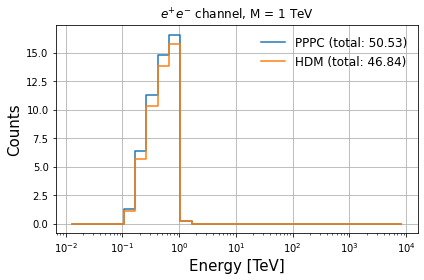

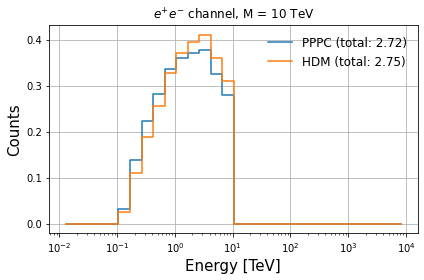

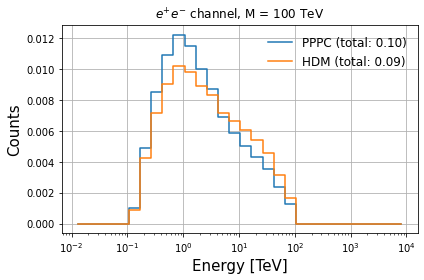

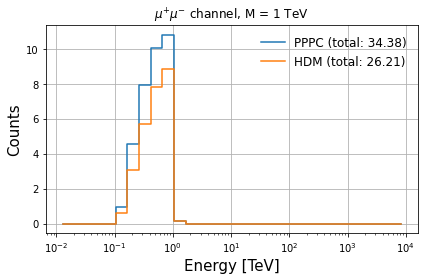

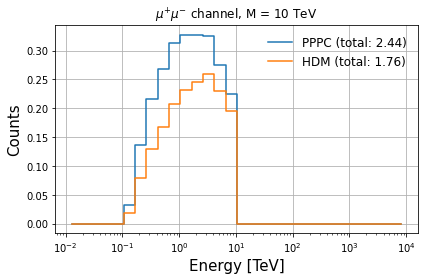

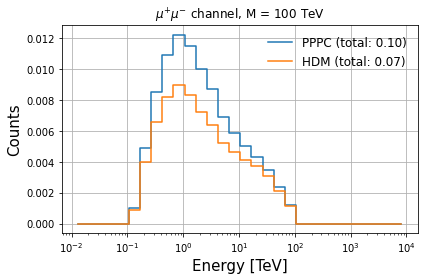

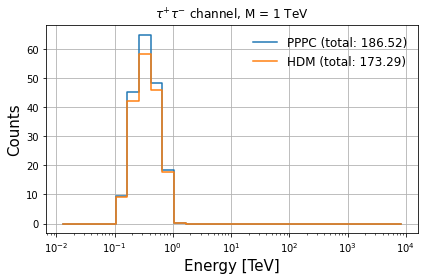

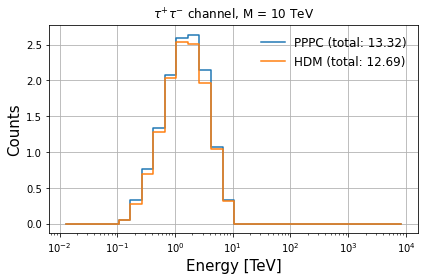

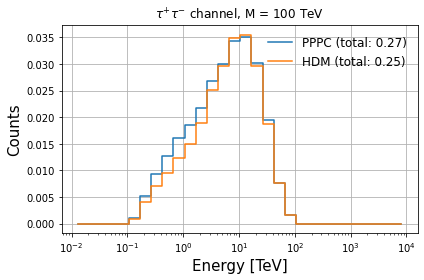

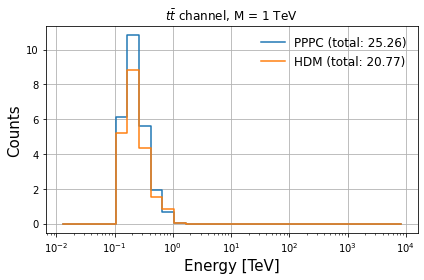

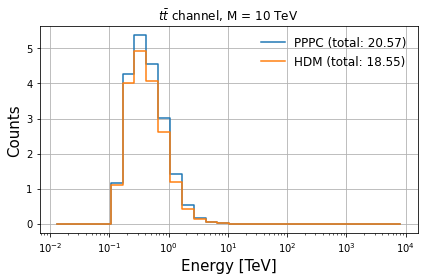

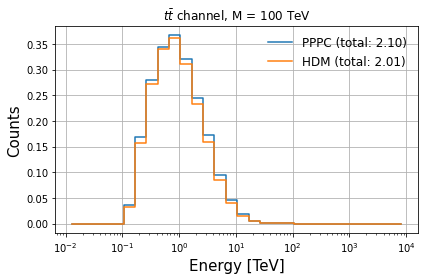

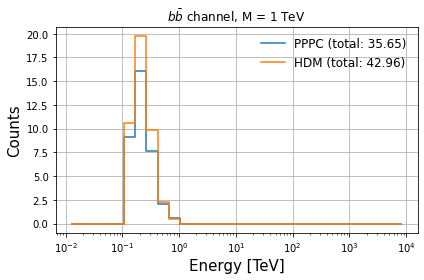

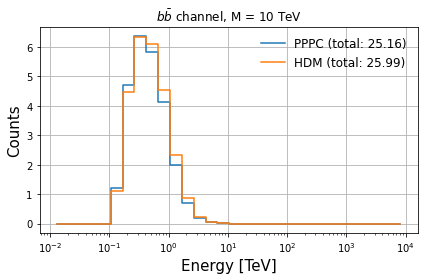

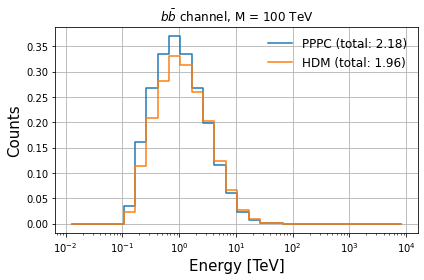

Negative dN/dx values were set to 0 for the following x:
[0.9962723]
Caution around these values should be taken
A comparison with linear interpolation is recommended


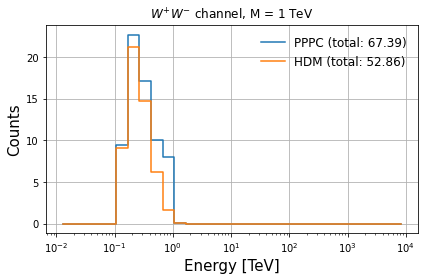

Negative dN/dx values were set to 0 for the following x:
[0.98508919 0.98881689]
Caution around these values should be taken
A comparison with linear interpolation is recommended


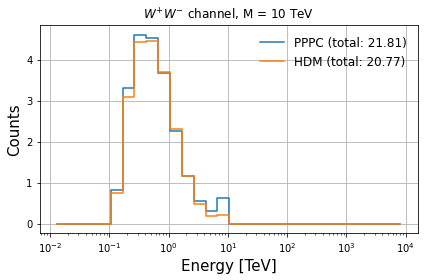

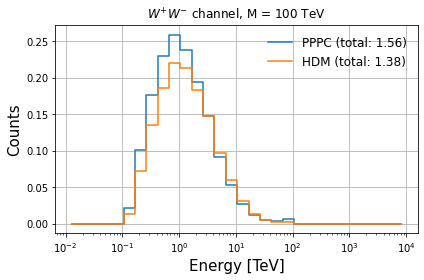

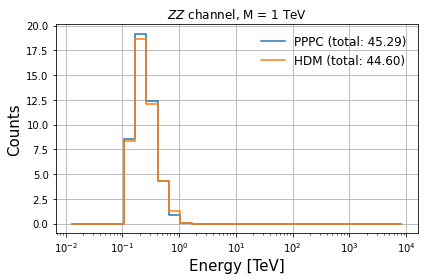

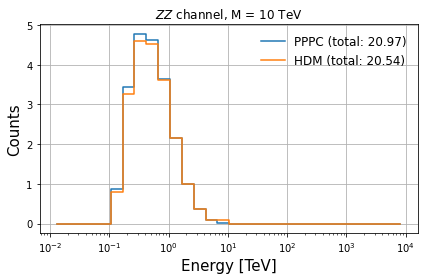

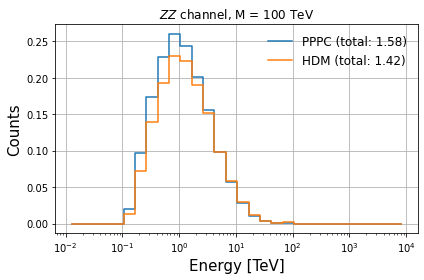

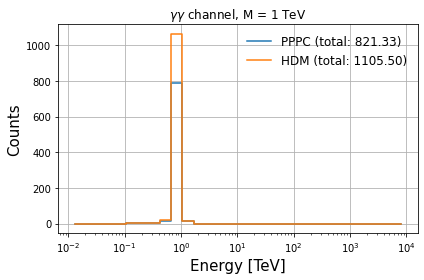

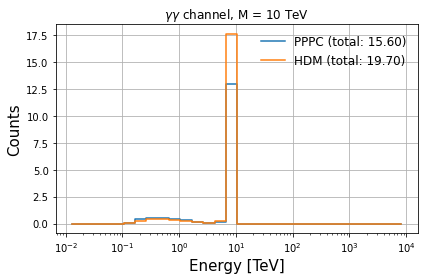

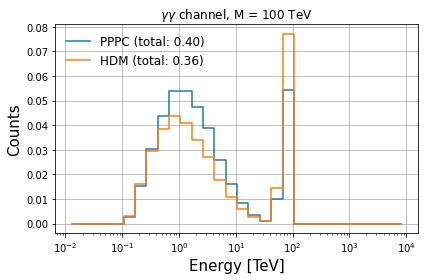

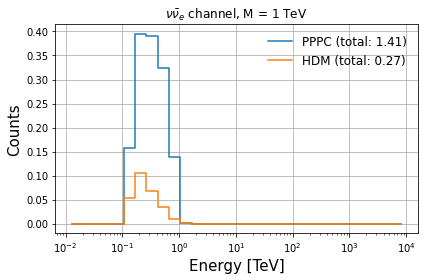

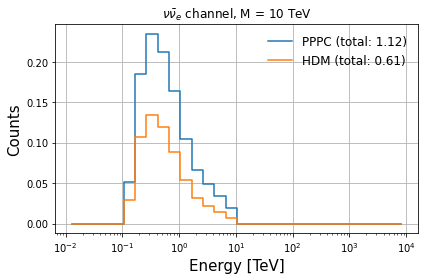

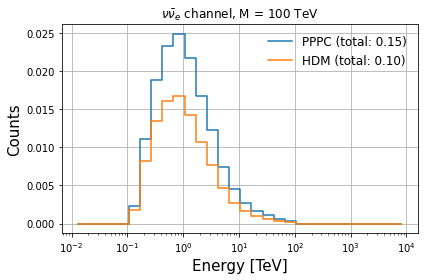

In [5]:
E = [1000, 10000, 100000]
cnts = {}

chan = ["ee", "uu", "tt", "ttbar", "bbar", "WW", "ZZ", "gamma", "nue"]
chan_lab = [r"$e^{+}e^{-}$", r"$\mu^{+}\mu^{-}$", r"$\tau^{+}\tau^{-}$", 
            r"$t\bar{t}$", r"$b\bar{b}$",
            r"$W^{+}W^{-}$", r"$ZZ$", r"$\gamma\gamma$", r"$\nu \bar{\nu}_e$"]
for c, cl in zip(chan, chan_lab):
    for en in E:
        sig_vts = Likelihood.calcSignal(dwarf, en, irf, jArray=True, jProfile=jProfile, channel=c)
        sig_vts_hdm = Likelihood.calcSignal(dwarf, en, irf, jArray=True, jProfile=jProfile, DM_spectra="HDM", channel=c)
        x1, y1 = getArray(sig_vts)
        x2, y2 = getArray(sig_vts_hdm)
        plt.step(x1/1e3, y1, label="PPPC (total: {:.2f})".format(sum(y1)), where="mid")
        plt.step(x2/1e3, y2, label="HDM (total: {:.2f})".format(sum(y2)), where="mid")
        plt.xscale("log")
        plt.title("{} channel, M = {:.0f} TeV".format(cl, en/1000))
        plt.grid()
        plt.legend(frameon=False, fontsize=12)
        plt.xlabel("Energy [TeV]", fontsize=15)
        plt.ylabel("Counts", fontsize=15)
        plt.tight_layout()
        plt.savefig("{}-{}.png".format(c, en))
        plt.show(block=False)

In [44]:
const.mass4gamma_disp[15]

12589.254117941662

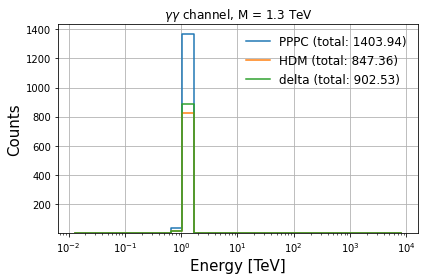

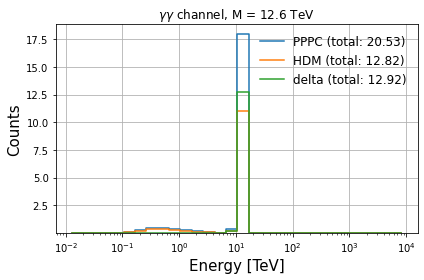

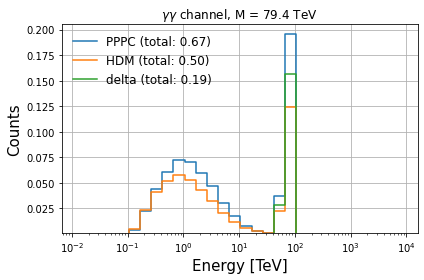

In [45]:
E = [const.mass4gamma_disp[10], const.mass4gamma_disp[15], const.mass4gamma_disp[19]]
cnts = {}

chan = ["gamma"]
chan_lab = [r"$\gamma\gamma$"]
for c, cl in zip(chan, chan_lab):
    for en in E:
        sig_vts = Likelihood.calcSignal(dwarf, en, irf, jArray=True, jProfile=jProfile, channel=c)
        sig_vts_hdm = Likelihood.calcSignal(dwarf, en, irf, jArray=True, jProfile=jProfile, DM_spectra="HDM", channel=c)
        sig_vts_det = Likelihood.calcSignal(dwarf, en, irf, jArray=True, jProfile=jProfile, DM_spectra="HDM", channel="delta")
        x1, y1 = getArray(sig_vts)
        x2, y2 = getArray(sig_vts_hdm)
        x3, y3 = getArray(sig_vts_det)
        plt.step(x1/1e3, y1, label="PPPC (total: {:.2f})".format(sum(y1)), where="mid")
        plt.step(x2/1e3, y2, label="HDM (total: {:.2f})".format(sum(y2)), where="mid")
        plt.step(x3/1e3, y3, label="delta (total: {:.2f})".format(sum(y3)), where="mid")
        plt.xscale("log")
#        plt.yscale("log")
        plt.ylim(1e-3, )
        plt.title("{} channel, M = {:.1f} TeV".format(cl, en/1000))
        plt.grid()
        plt.legend(frameon=False, fontsize=12)
        plt.xlabel("Energy [TeV]", fontsize=15)
        plt.ylabel("Counts", fontsize=15)
        plt.tight_layout()
        plt.savefig("{}-{}.png".format(c, en))
        plt.show(block=False)

In [49]:
E = np.logspace(2.5, 8, 10)
dwarf = "segue_1"
cnts = {}
jProfile = JProfile.generateConvolvedJ(dwarf, irf=irf, seed=defaultNum[dwarf], return_array=True, save_root=False)
chan = ["ee", "uu", "tt", "ttbar", "bbar", "WW", "ZZ", "gamma", "nue"]
for c in chan:
    cnts[c] = []
    if c == "gamma":
        E = const.mass4gamma_disp
    else:
        E = np.logspace(2.5, 8, 10)
    for en in tqdm(E):
        sig_vts = Likelihood.calcSignal(dwarf, en, irf, jArray=True, jProfile=jProfile, channel=c)
        sig_vts_hdm = Likelihood.calcSignal(dwarf, en, irf, jArray=True, jProfile=jProfile, DM_spectra="HDM", channel=c)
        cnts[c].append([sum(getArray(sig_vts)[1]), sum(getArray(sig_vts_hdm)[1]) ])
    cnts[c] = np.asarray(cnts[c])

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Negative dN/dx values were set to 0 for the following x:
[0.85406945 0.86319011 0.86547028 0.86775044 0.87003061 0.87231077
 0.87459093 0.8768711  0.87915126 0.88143143 0.88371159 0.88599176
 0.88827192 0.89055209 0.89283225 0.89511242 0.9612372  0.96351736
 0.96579753 0.96807769 0.97035786 0.97263802 0.98631901]
Caution around these values should be taken
A comparison with linear interpolation is recommended
Negative dN/dx values were set to 0 for the following x:
[0.97770054 0.98017826 0.98265598]
Caution around these values should be taken
A comparison with linear interpolation is recommended
Negative dN/dx values were set to 0 for the following x:
[0.99465944]
Caution around these values should be taken
A comparison with linear interpolation is recommended


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [50]:
gamma_mass = const.mass4gamma_disp
cnt_delta = []
temp = []
for en in tqdm(gamma_mass):
    sig_pppc = Likelihood.calcSignal(dwarf, en, irf, jArray=True, jProfile=jProfile, channel="gamma")
    sig_hdm = Likelihood.calcSignal(dwarf, en, irf, jArray=True, jProfile=jProfile, DM_spectra="HDM", channel="gamma")
    sig_delta = Likelihood.calcSignal(dwarf, en, irf, jArray=True, jProfile=jProfile, channel="delta")
    temp.append([sum(getArray(sig_pppc)[1]), sum(getArray(sig_hdm)[1])])
    cnt_delta.append(sum(getArray(sig_delta)[1]))
cnt_delta = np.asarray(cnt_delta)
cnts["gamma"] = np.asarray(temp)

  0%|          | 0/30 [00:00<?, ?it/s]

In [51]:
chan = ["ee", "uu", "tt", "ttbar", "bbar", "WW", "ZZ", "gamma", "nue"]
chan_lab = [r"$e^{+}e^{-}$", r"$\mu^{+}\mu^{-}$", r"$\tau^{+}\tau^{-}$", 
            r"$t\bar{t}$", r"$b\bar{b}$",
            r"$W^{+}W^{-}$", r"$ZZ$", r"$\gamma\gamma$", r"$\nu \bar{\nu}_e$"]

/var/folders/cb/7rc9frgd0gn_mk4qbpns1bdm0000gn/T/ipykernel_13697/3797755246.py:15: RuntimeWarning: divide by zero encountered in true_divide
  ax[1].plot(E/1e3, cnt[:,0]/cnt[:,1], color="k")
/var/folders/cb/7rc9frgd0gn_mk4qbpns1bdm0000gn/T/ipykernel_13697/3797755246.py:15: RuntimeWarning: divide by zero encountered in true_divide
  ax[1].plot(E/1e3, cnt[:,0]/cnt[:,1], color="k")
/var/folders/cb/7rc9frgd0gn_mk4qbpns1bdm0000gn/T/ipykernel_13697/3797755246.py:15: RuntimeWarning: divide by zero encountered in true_divide
  ax[1].plot(E/1e3, cnt[:,0]/cnt[:,1], color="k")
/var/folders/cb/7rc9frgd0gn_mk4qbpns1bdm0000gn/T/ipykernel_13697/3797755246.py:15: RuntimeWarning: divide by zero encountered in true_divide
  ax[1].plot(E/1e3, cnt[:,0]/cnt[:,1], color="k")
/var/folders/cb/7rc9frgd0gn_mk4qbpns1bdm0000gn/T/ipykernel_13697/3797755246.py:15: RuntimeWarning: divide by zero encountered in true_divide
  ax[1].plot(E/1e3, cnt[:,0]/cnt[:,1], color="k")
/var/folders/cb/7rc9frgd0gn_mk4qbpns1bdm0000g

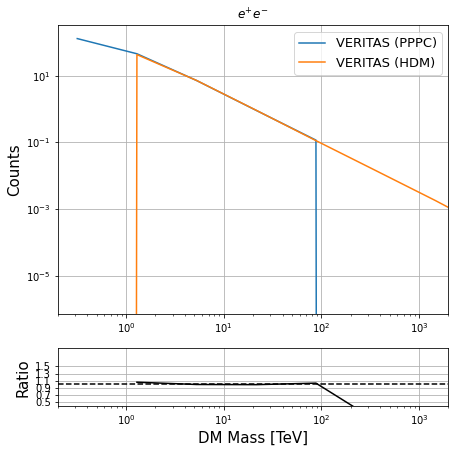

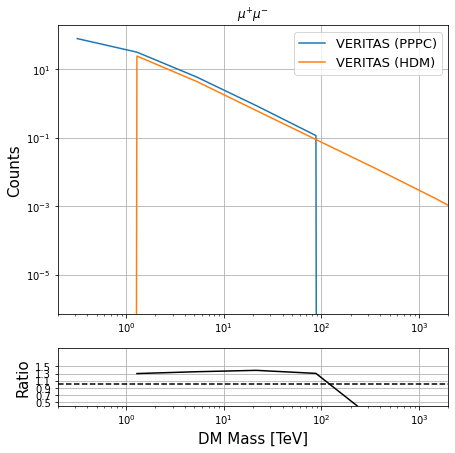

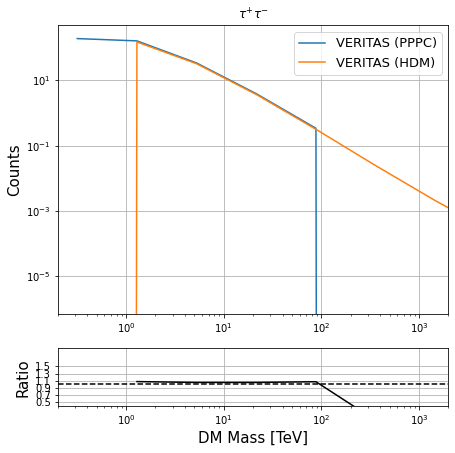

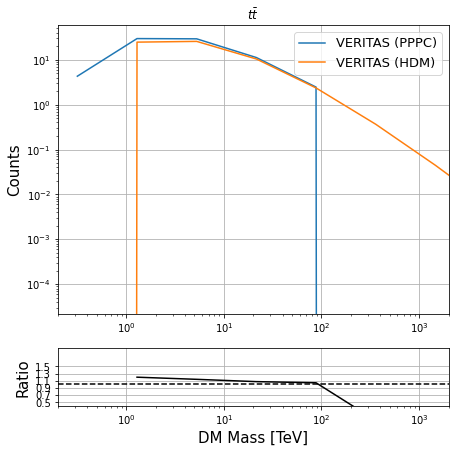

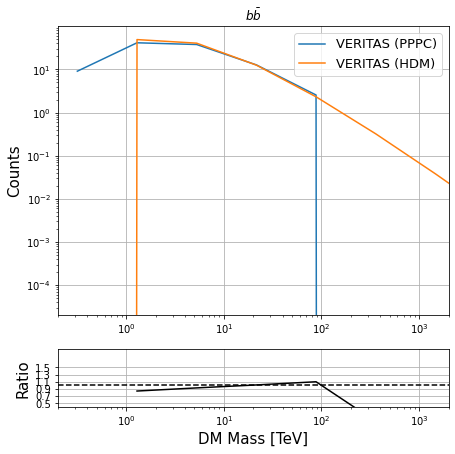

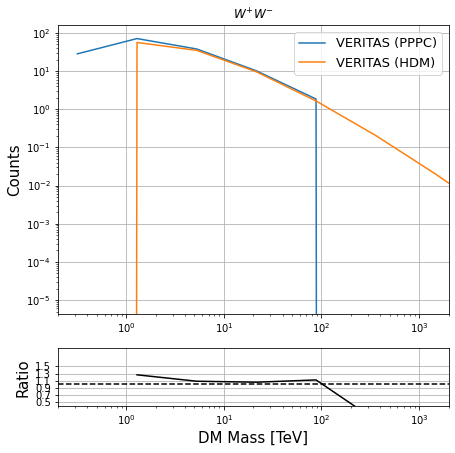

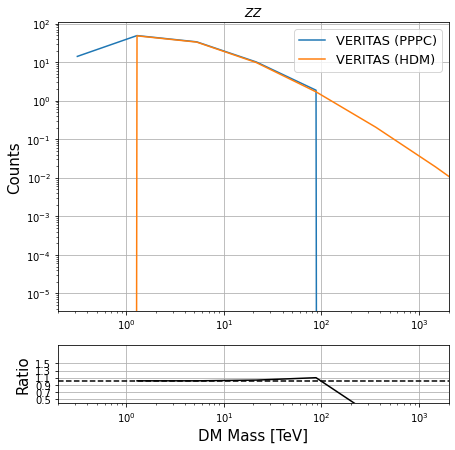

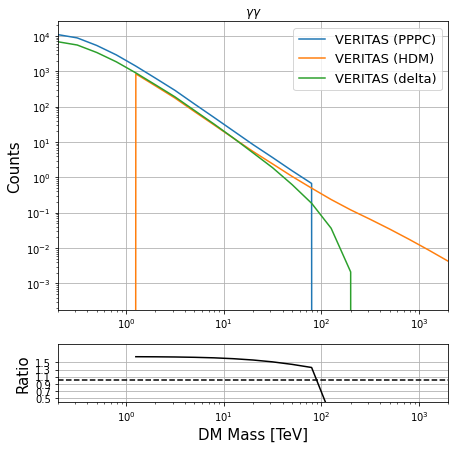

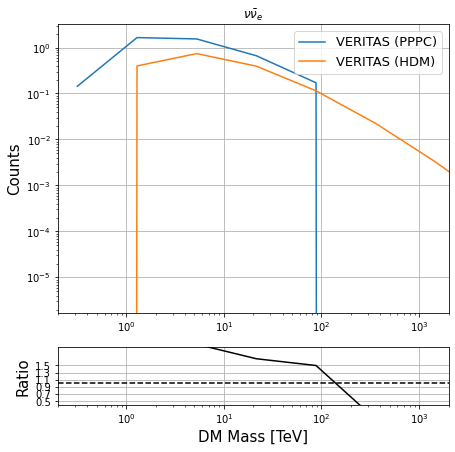

In [53]:
E = np.logspace(2.5, 8, 10)
for c, cl in zip(chan, chan_lab):
    cnt = cnts[c]
    f, ax = plt.subplots(2,1, figsize=(7, 7), gridspec_kw={'height_ratios':[5,1]})

    if c == "gamma":

        etc = ax[0].plot(gamma_mass/1e3, cnt[:,0], label="VERITAS (PPPC)")
        etc2 = ax[0].plot(gamma_mass/1e3, cnt[:,1], label="VERITAS (HDM)")
        ax[0].plot(gamma_mass/1e3, cnt_delta, label="VERITAS (delta)")
        ax[1].plot(gamma_mass/1e3, cnt[:,0]/cnt[:,1], color="k")
    else:
        etc = ax[0].plot(E/1e3, cnt[:,0], label="VERITAS (PPPC)")
        etc2 = ax[0].plot(E/1e3, cnt[:,1], label="VERITAS (HDM)")
        ax[1].plot(E/1e3, cnt[:,0]/cnt[:,1], color="k")
    ax[0].set_xscale("log")
    ax[0].set_yscale("log")
    ax[0].grid()
    ax[0].set_ylabel("Counts", fontsize=15)
    ax[0].legend(fontsize=13)
    ax[0].set_xlim(0.2, 2e3)
    ax[0].set_title(cl)
    
    ax[1].set_xscale("log")
    ax[1].set_xlabel("DM Mass [TeV]", fontsize=15)
    ax[1].set_ylim(0.4, 2)
    ax[1].set_yticks([0.5, 0.7, 0.9, 1.1, 1.3, 1.5])
    ax[1].axhline(1, color="k", ls="--")
    ax[1].grid()
    ax[1].set_ylabel("Ratio", fontsize=15)
    ax[1].set_xlim(0.2, 2e3)
    plt.savefig(f"{c}-totcont.png")

## Step 8: Simulation study - significance plot

### Define ideal IRFs

In [3]:
dwarf = "segue_1"

irf = ResponseFunction.VEGAS.readIRFs(dwarf)
irf.exposure = 50*3600
jProfile_vts = JProfile.generateConvolvedJ(dwarf, irf=irf, seed=defaultNum[dwarf], return_array=True, save_root=False)

[Warning] IRFs and package are mismatched. The package name is changed from EventDisplay to VEGAS.


  0%|          | 0/101 [00:00<?, ?it/s]

### Calculate total counts

In [4]:
M = np.load(SCRIPT_DIR+"/npy/mass4gamma_vegas.npy")

In [16]:
chan = ["ee", "uu", "tt", "ttbar", "bbar", "WW", "ZZ", "gamma", "nue"]
chan_lab = [r"$e^{+}e^{-}$", r"$\mu^{+}\mu^{-}$", r"$\tau^{+}\tau^{-}$", 
            r"$t\bar{t}$", r"$b\bar{b}$",
            r"$W^{+}W^{-}$", r"$Z^{+}Z^{-}$", r"$\gamma^{+}\gamma^{-}$", r"$\nu_e \bar{\nu_e}$"]

M = np.logspace(4.5, 7.5, 30)

cnts = {}
for c in chan:
    cnts[c] = []
    if c == "gamma":
        M = np.load(SCRIPT_DIR+"/npy/mass4gamma_vegas.npy")
        M = M[(M>10**4.5)*(M<10**9)]
    else:
        M = np.logspace(4.5, 7.5, 30)
    for en in tqdm(M):
        sig_fake_hdm = 0
#        sig_fake_hdm = Likelihood.calcSignal(dwarf, en, newirf, jArray=True, jProfile=jProfile_fake, DM_spectra="HDM", channel=c)
        sig_vts_hdm = Likelihood.calcSignal(dwarf, en, irf, jArray=True, jProfile=jProfile_vts, DM_spectra="HDM", channel=c)
        cnts[c].append([en, sum(getArray(sig_vts_hdm)[1])])
    cnts[c] = np.asarray(cnts[c])

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Negative dN/dx values were set to 0 for the following x:
[0.99450758]
Caution around these values should be taken
A comparison with linear interpolation is recommended


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Warning in <TROOT::Append>: Replacing existing TH1: hg_1D (Potential memory leak).


### Plotting total count vs mass

Text(0.5, 0, 'DM Mass [TeV]')

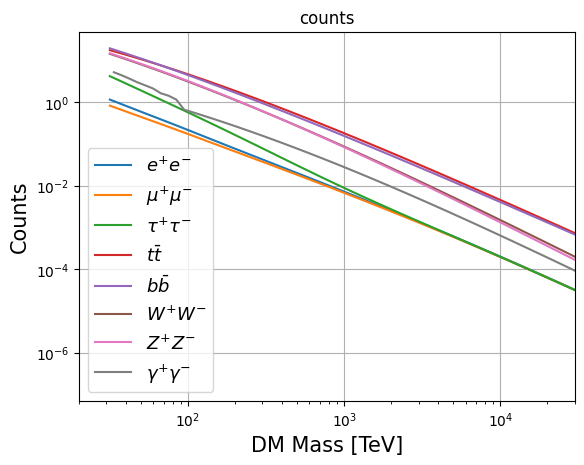

In [9]:
f, ax = plt.subplots(1,1)
for c, cl in zip(chan, chan_lab):
    M = cnts[c][:,0]
    cnt = cnts[c]
    
    etc = ax.plot(M/1e3, cnt[:,1], label=cl)
#    f_mass = interp1d(np.log10(M/1e3), np.log10(cnt[:,1]))
#    etc = ax.plot(np.logspace(1.53, 5.9, 100), 10**f_mass(np.linspace(1.53, 5.9, 100)), label="fit", ls="--", color=etc[0].get_color())

ax.set_xscale("log")
ax.set_yscale("log")
ax.grid()
ax.set_ylabel("Counts", fontsize=15)
ax.legend(fontsize=13)
ax.set_xlim(20, 3e4)
ax.set_title("counts")
ax.set_xlabel("DM Mass [TeV]", fontsize=15)


### Significance plot for VERITAS

In [10]:
plt.style.use("default")

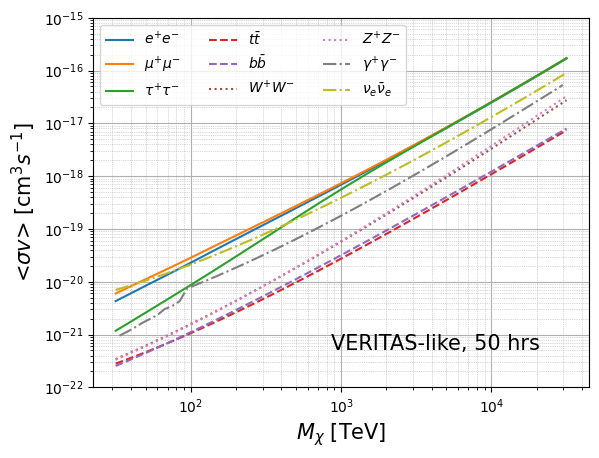

In [19]:
events = Likelihood.VEGAS.readData(dwarf, rawdata=True)
N_bkg = sum(events[:,2] == 0)
temp = ResponseFunction.VEGAS.readIRFs(dwarf)
t_ratio = temp.exposure/180000
N_bkg = N_bkg/t_ratio
#alpha = events[:,3][0]
alpha = 0.131

chan = ["ee", "uu", "tt", "ttbar", "bbar", "WW", "ZZ", "gamma", "nue"]
chan_lab = [r"$e^{+}e^{-}$", r"$\mu^{+}\mu^{-}$", r"$\tau^{+}\tau^{-}$", 
            r"$t\bar{t}$", r"$b\bar{b}$",
            r"$W^{+}W^{-}$", r"$Z^{+}Z^{-}$", r"$\gamma^{+}\gamma^{-}$", r"$\nu_e \bar{\nu}_e$"]

ls = ["-", "-", "-", "--", "--", ":",":", "-.", "-."]

sigma = np.logspace(-22, -10, 30)

M = np.logspace(4.5, 7.5, 30)

for c, cl, l in zip(chan, chan_lab, ls):
    M = cnts[c][:,0]
    cnt = cnts[c]
#    f_mass = interp1d(np.log10(M/1e3), np.log10(cnt[:,1]))
    five_sig = []
    if c == "gamma":
        M = np.load(SCRIPT_DIR+"/npy/mass4gamma_vegas.npy")
        M = M[(M>10**4.5)*(M<10**7.5)]
    for i, m in enumerate(M):
        temp = []
        for j, s in enumerate(sigma):
            sig = LiMaSiginficance(N_bkg*alpha+cnt[i][1]*s/1e-23, N_bkg, alpha=alpha)
            temp.append(sig)
        test = interp1d(np.log10(temp), np.log10(sigma))
        five_sig.append(test(np.log10(5)))
    five_sig = np.asarray(five_sig)
    plt.plot(M/1e3, 10**five_sig,  label=cl, ls=l)
    data = np.asarray([M/1e3, 10**five_sig]).T
    np.save(f"vts_like_{c}_disc", data)
    
plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-22, 1e-15)
plt.grid()

plt.legend(ncol=3)
plt.xlabel(r"$M_{\chi}$ [TeV]", fontsize=15)
plt.ylabel(r"<$\sigma v$> [cm$^{3}s^{-1}$]", fontsize=15)

ax = plt.gca()
plt.text(0.9, 0.1, "VERITAS-like, 50 hrs", fontsize=15, ha="right", transform=ax.transAxes)
#plt.text(0.9, 0.2, r"$\mathcal{S}$ = 5$\sigma$", fontsize=15, ha="right", transform=ax.transAxes)

plt.grid(b=True, which="major")
plt.grid(b=True, which="minor", ls=":", lw=0.5)
plt.xlim()
plt.savefig("VERITAS_disc.pdf")

### Background fit

In [ ]:
dwarf = "ursa_minor"
M =1000
package="VEGAS"
jSeed=defaultNum[dwarf]
mle_1d = Likelihood.MLE(dwarf, M, channel="tt",
                     package=package,
                     addTheta=False, 
                     averagedIRF=True,
                     ext=False,
                     useBias=True,
                     jArray=True,
                     jSeed=jSeed,
                     version="all",
                     bkgModel=None,
                     verbose=3) 

mle_1d.bkg_minuit(model="powerlaw")
logl_pl = mle_1d.bkg_logl
pars_pl = mle_1d.bkg_pars

mle_1d.bkg_minuit(model="bknpl")
logl_bknpl = mle_1d.bkg_logl
pars_bknpl = mle_1d.bkg_pars

mle_1d.bkg_minuit(model="powerlaw", fix_idx=True, index=-2.57)
logl_pl_fix = mle_1d.bkg_logl
pars_pl_fix = mle_1d.bkg_pars


print("BIC = {}".format(logl_pl-logl_bknpl-2*np.log(sum(mle_1d.args["hOff"] !=0)-1)))


### Plot background fit 

In [ ]:
x, y = getArray(mle_1d.hOff)
plt.step(x/1e3, y, where="mid", label="Observed events")

bkg_fit = Likelihood.forwardFolding(utils.POWERLAW, pars_pl, dwarf, irf=irf, alpha=mle_1d.alpha)
fitx, fity = getArray(bkg_fit)
plt.step(fitx/1e3, fity, where="mid", ls="--", label="Power-law (C stat: {:.1f})".format(logl_pl))

bkg_fit = Likelihood.forwardFolding(utils.BKNPOWER, pars_bknpl, dwarf, irf=irf, alpha=mle_1d.alpha)
fitx, fity = getArray(bkg_fit)
plt.step(fitx/1e3, fity, where="mid", ls="--", label="Broken PL (C stat: {:.1f})".format(logl_bknpl))

bkg_fit = Likelihood.forwardFolding(utils.POWERLAW, pars_pl_fix, dwarf, irf=irf, alpha=mle_1d.alpha)
fitx, fity = getArray(bkg_fit)
plt.step(fitx/1e3, fity, where="mid", ls="--", label="PL (C stat: {:.1f})".format(logl_pl_fix))

plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.ylim(1e-1)
plt.legend(fontsize=12)
plt.xlabel("Energy [TeV]", fontsize=15)
plt.ylabel("Observed counts", fontsize=15)
#plt.text("BIC = {}".format(logl_pl-logl_bknpl-2*np.log(sum(mle_1d.args["hOff"] !=0)-1)))

### Get background counts for ideal IRFs

In [ ]:
x, y = getArray(mle_1d.hOff)
plt.step(x/1e3, y, where="mid", label="VERITAS")

xi, yi = getArray(bkg_fit)
plt.step(xi/1e3, yi, where="mid", label="PL fit")

plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.ylim(1e-2)
plt.legend(fontsize=12)
plt.xlabel("Energy [TeV]", fontsize=15)
plt.ylabel("Observed counts", fontsize=15)

### Significance plot for ideal IRFs

In [ ]:
chan = ["ee", "uu", "tt", "ttbar", "bbar", "WW", "ZZ", "gamma"]
chan_lab = [r"$e^{+}e^{-}$", r"$\mu^{+}\mu^{-}$", r"$\tau^{+}\tau^{-}$",
            r"$t\bar{t}$", r"$b\bar{b}$",
            r"$W^{+}W^{-}$", r"$Z^{+}Z^{-}$", r"$\gamma\gamma$"]

ls = ["-", "-", "-", "--", "--", ":",":", "-."]
events = Likelihood.VEGAS.readData(dwarf, rawdata=True)
bkg_fit = Likelihood.forwardFolding(utils.POWERLAW, pars_pl_fix, dwarf, irf=newirf, alpha=1)
x, y = getArray(bkg_fit)
mass = np.logspace(1.53, 4.45, 30)
sigma = np.logspace(-23, -15, 30)
temp = ResponseFunction.VEGAS.readIRFs(dwarf)
t_ratio = temp.exposure/(50*3600)
N_bkg = sum(y) / t_ratio
alpha = events[:,3][0]


for c, cl, l in zip(chan, chan_lab, ls):
    M = cnts[c][:,0]
    cnt = cnts[c]
    f_mass = interp1d(np.log10(M/1e3), np.log10(cnt[:,2]))
    five_sig = []
    for i, m in enumerate(mass):
        temp = []
        for j, s in enumerate(sigma):
            sig = LiMaSiginficance(N_bkg*alpha+10**f_mass(np.log10(m))*s/1e-23, N_bkg, alpha=alpha)
            temp.append(sig)
        test = interp1d(np.log10(temp), np.log10(sigma))
        five_sig.append(test(np.log10(5)))
    five_sig = np.asarray(five_sig)
    plt.plot(mass, 10**five_sig,  label=cl, ls=l)
plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-23, 1e-16)
plt.grid()

plt.legend(ncol=2)
plt.xlabel("DM mass [TeV]", fontsize=12)
plt.ylabel(r"<$\sigma\nu$> [cm$^{3}s^{-1}$]", fontsize=12)


## Step 9: Expected upper limits

### VERITAS

In [2]:
dwarf = "segue_1"
mass = np.logspace(4.5, 7.5, 5)
package="VEGAS"
jSeed=defaultNum[dwarf]

chan = ["ee", "uu", "tt", "ttbar", "bbar", "WW", "ZZ", "gamma", ""]
chan_lab = [r"$e^{+}e^{-}$", r"$\mu^{+}\mu^{-}$", r"$\tau^{+}\tau^{-}$",
            r"$t\bar{t}$", r"$b\bar{b}$",
            r"$W^{+}W^{-}$", r"$Z^{+}Z^{-}$", r"$\gamma\gamma$"]

jProfile_vts = JProfile.generateConvolvedJ(dwarf, seed=defaultNum[dwarf], return_array=True, save_root=False, package="VEGAS")

irf = ResponseFunction.VEGAS.readIRFs(dwarf)
irf.exposure = 50*3600
events = Likelihood.VEGAS.readData(dwarf, rawdata=True)

N_on_vts = sum(events[:,2] == 1)/t_ratio
N_off_vts = sum(events[:,2] == 0)/t_ratio

for channel in chan:
    filename = "veritas_{}".format(channel)
    Likelihood.calcExpectedLimits(dwarf, channel, irf = irf, package=package, mass=mass, method=2, averagedIRF=True, DM_spectra="HDM",
                                  jArray=True, jSeed=jSeed, jProfile=jProfile_vts, addTheta=False, version="all", ext=False, 
                                  useBias=True, verbosity=0, runs=100, filename=filename, multi=True,
                                  N_on=N_on_vts, N_off=N_off_vts)

  0%|          | 0/101 [00:00<?, ?it/s]


KeyboardInterrupt



In [ ]:
chan = ["ee", "uu", "tt", "ttbar", "bbar", "WW", "ZZ", "gamma"]
chan_lab = [r"$e^{+}e^{-}$", r"$\mu^{+}\mu^{-}$", r"$\tau^{+}\tau^{-}$",
            r"$t\bar{t}$", r"$b\bar{b}$",
            r"$W^{+}W^{-}$", r"$Z^{+}Z^{-}$", r"$\gamma\gamma$"]

ls = ["-", "-", "-", "--", "--", ":",":", "-."]

for c, cl, l in zip(chan, chan_lab, ls):
    filename = "veritas_"+c
    Likelihood.plotExpULcurve(filename=filename, label=cl, units="TeV", ls=l, mean_only=True)

### Ideal

In [ ]:
from DarkMatter.Likelihood.simulation import gen_evt_1d

In [ ]:
dwarf = "ursa_minor"

newirf = ResponseFunction.newirf("VEGAS")
gJProf = JProfile.calcJProfile(dwarf, seed=defaultNum[dwarf])
gPSF1D_fake = ResponseFunction.fakePSF(0.02)
J_fake, e = JProfile.calcHKConvJProf2D(gJProf, gPSF1D_fake, package="VEGAS")
jProfile_fake = interp1d([10, 1e20], [J_fake, J_fake])
newirf.EA = ResponseFunction.fakeEA(1e6, benchmark="VEGAS", low_cutoff=0.4, s=1.2)
newirf.exposure = 50*3600
newirf.Bias = ResponseFunction.fakeBias(0.08, benchmark="VEGAS")

irf = ResponseFunction.VEGAS.readIRFs(dwarf)
t_ratio = irf.exposure/(50*3600)
events = Likelihood.VEGAS.readData(dwarf, rawdata=True)
alpha = events[:,3][0]
bkg_fit = Likelihood.forwardFolding(utils.POWERLAW, pars_pl_fix, dwarf, irf=newirf, alpha=1)
x, y = getArray(bkg_fit)
N_temp = sum(getArray(bkg_fit)[1])
N_off_ideal = sum(y)/t_ratio
N_on_ideal = N_off_ideal*alpha
new_evts = gen_evt_1d(bkg_fit)
eventset = np.asarray([[evt[0], 0, 0, alpha] for evt in new_evts])
hOn, hOff = Likelihood.eventdisplay.readData(dwarf, events=eventset)

In [ ]:
dwarf = "ursa_minor"
mass = np.logspace(4.5, 7.5, 5)
package="EventDisplay"
jSeed=defaultNum[dwarf]

chan = ["ee", "uu", "tt", "ttbar", "bbar", "WW", "ZZ", "gamma"]
chan_lab = [r"$e^{+}e^{-}$", r"$\mu^{+}\mu^{-}$", r"$\tau^{+}\tau^{-}$",
            r"$t\bar{t}$", r"$b\bar{b}$",
            r"$W^{+}W^{-}$", r"$Z^{+}Z^{-}$", r"$\gamma\gamma$"]

for channel in chan:
    filename = "ideal_{}".format(channel)
    Likelihood.calcExpectedLimits(dwarf, channel, irf = newirf, mass=mass, method=2, averagedIRF=True, DM_spectra="HDM",
                                  jArray=True, jSeed=jSeed, jProfile=jProfile_fake, addTheta=False, version="all", ext=False, 
                                  useBias=True, verbosity=0, runs=10, filename=filename, multi=True, test=True,
                                  N_on=N_on_ideal, events=new_evts, alpha = alpha, hOff=hOff, N_off=N_off_ideal)

In [ ]:
chan = ["ee", "uu", "tt", "ttbar", "bbar", "WW", "ZZ", "gamma"]
chan_lab = [r"$e^{+}e^{-}$", r"$\mu^{+}\mu^{-}$", r"$\tau^{+}\tau^{-}$",
            r"$t\bar{t}$", r"$b\bar{b}$",
            r"$W^{+}W^{-}$", r"$Z^{+}Z^{-}$", r"$\gamma\gamma$"]

ls = ["-", "-", "-", "--", "--", ":",":", "-."]

for c, cl, l in zip(chan, chan_lab, ls):
    filename = "ideal_"+c
    Likelihood.plotExpULcurve(filename=filename, label=cl, units="TeV", ls=l, mean_only=True)

## 10. Final results

### VERITAS-like

In [20]:
dwarf = "Segue_1"

package="VEGAS"
jSeed=defaultNum[dwarf]

chan = ["tt"]
chan_lab = [r"$e^{+}e^{-}$", r"$\mu^{+}\mu^{-}$", r"$\tau^{+}\tau^{-}$",
            r"$t\bar{t}$", r"$b\bar{b}$",
            r"$W^{+}W^{-}$", r"$Z^{+}Z^{-}$", r"$\gamma\gamma$"]

jProfile_vts = JProfile.generateConvolvedJ(dwarf, package="VEGAS", general=True, seed=defaultNum[dwarf], return_array=True, save_root=False)
irf = ResponseFunction.VEGAS.readIRFs(dwarf)
t_ratio = irf.exposure/(50*3600)
events = Likelihood.VEGAS.readData(dwarf, rawdata=True)
N_on_vts = sum(events[:,2]==1)/t_ratio
N_off_vts = sum(events[:,2]==0)/t_ratio
alpha = 0.131
z, m_test, y = getArray(irf.Edisp)

irf.exposure = 50*3600
mass = np.logspace(4.5, 7.5, 5)


  0%|          | 0/101 [00:00<?, ?it/s]

In [21]:
dwarf = "Segue_1"
irf = ResponseFunction.VEGAS.readIRFs(dwarf)
t_ratio = irf.exposure/(50*3600)
events = Likelihood.VEGAS.readData(dwarf, rawdata=True)
N_on_vts = sum(events[:,2]==1)/t_ratio
N_off_vts = sum(events[:,2]==0)/t_ratio
alpha = 0.131
z, m_test, y = getArray(irf.Edisp)

irf.exposure = 50*3600
mass = const.mass4gamma_vegas
mass = np.logspace(4.5, 7.5, 5)

In [22]:
filename = "vts_like_tt"
channel = "tt"

Likelihood.calcExpectedLimits(dwarf, channel, package=package, irf = irf, general=True, mass=mass, method=2, averagedIRF=True, DM_spectra="HDM",
                                  jArray=True, jProfile=jProfile_vts, addTheta=False, version="all", ext=False, multi=False,
                                  useBias=True, verbosity=0, runs=100, filename=filename, test=True, seed=9, statistic="simple",
                                  N_on=N_on_vts, alpha = alpha, N_off = N_off_vts)

  0%|          | 0/500 [00:00<?, ?it/s]

[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
irf = ResponseFunction.VEGAS.readIRFs(dwarf)
events = Likelihood.VEGAS.readData(dwarf, rawdata=True)
channel = "bbar"
for t in [48]:
    
    t_ratio = irf.exposure/(t*3600)    
    N_on_vts = sum(events[:,2]==1)/t_ratio
    N_off_vts = sum(events[:,2]==0)/t_ratio
    alpha = 0.131
    irf.exposure = t*3600
    mass = [1e5, 1e6, 1e7]
    filename = f"sanity_check_{t}"
    Likelihood.calcExpectedLimits(dwarf, channel, package=package, irf = irf, mass=mass, method=2, averagedIRF=True, DM_spectra="HDM",
                                      jArray=True, jSeed=jSeed, jProfile=jProfile_vts, addTheta=False, version="all", ext=False, multi=False,
                                      useBias=True, verbosity=0, runs=100, filename=filename, test=True, seed=9, statistic="simple",
                                      N_on=N_on_vts, alpha = alpha, N_off = N_off_vts)

In [ ]:
uls_t = {1e5: [], 1e6:[], 1e7:[]}
for t in [40,50, 80, 120, 200, 300, 400, 500]:

    filename = f"sanity_check_{t}"
    uls = np.load(const.OUTPUT_DIR+filename+".npy", allow_pickle=True).item()
    for m in uls.keys():
        uls_t[m].append([t, np.average(uls[m])])

for m in [1e5, 1e6, 1e7]:
    uls_t[m] = np.asarray(uls_t[m])

In [ ]:
for m in [1e5, 1e6, 1e7]:
    plt.plot(uls_t[m][:,0], 10**uls_t[m][:,1], marker="x")
    
plt.plot(uls_t[m][:,0], 1/np.sqrt(uls_t[m][:,0])/1.5e19)
plt.xscale("log")
plt.yscale("log")

In [ ]:

for channel in chan:
    if channel == "gamma":
        mass = np.logspace(4.5, 7.5, 5)
        mass = [1e5, 1.1e5]
    filename = "vts_like_{}_add".format(channel)
    Likelihood.calcExpectedLimits(dwarf, channel, package=package, irf = irf, mass=mass, method=2, averagedIRF=True, DM_spectra="HDM",
                                  jArray=True, jSeed=jSeed, jProfile=jProfile_vts, addTheta=False, version="all", ext=False, multi=False,
                                  useBias=True, verbosity=0, runs=100, filename=filename, test=True, seed=9, statistic="simple",
                                  N_on=N_on_vts, alpha = alpha, N_off = N_off_vts)

In [42]:
const.OUTPUT_DIR

'/Users/dtak/Research/DarkMatter/Output/'

In [47]:
%ls /Users/dtak/Research/DarkMatter/Output/vts_like*

/Users/dtak/Research/DarkMatter/Output/vts_like_WW.npy
/Users/dtak/Research/DarkMatter/Output/vts_like_ZZ.npy
/Users/dtak/Research/DarkMatter/Output/vts_like_bbar.npy
/Users/dtak/Research/DarkMatter/Output/vts_like_ee.npy
/Users/dtak/Research/DarkMatter/Output/vts_like_gamma.npy
/Users/dtak/Research/DarkMatter/Output/vts_like_gamma_add.npy
/Users/dtak/Research/DarkMatter/Output/vts_like_tt.npy
/Users/dtak/Research/DarkMatter/Output/vts_like_ttbar.npy
/Users/dtak/Research/DarkMatter/Output/vts_like_ttbar_jsys.npy
/Users/dtak/Research/DarkMatter/Output/vts_like_ttbar_jsys_seed.npy
/Users/dtak/Research/DarkMatter/Output/vts_like_ttbar_sys.npy
/Users/dtak/Research/DarkMatter/Output/vts_like_uu.npy


In [53]:
const.mass4gamma_vegas

array([9.45625469e+00, 1.06100923e+01, 1.19047193e+01, 1.33573148e+01,
       1.49871537e+01, 1.68158630e+01, 1.88677086e+01, 2.11699173e+01,
       2.37530379e+01, 2.66513468e+01, 2.99033030e+01, 3.35520578e+01,
       3.76460280e+01, 4.22395381e+01, 4.73935413e+01, 5.31764279e+01,
       5.96649335e+01, 6.69451564e+01, 7.51137010e+01, 8.42789586e+01,
       9.45625469e+01, 1.06100923e+02, 1.19047193e+02, 1.33573148e+02,
       1.49871537e+02, 1.68158630e+02, 1.88677086e+02, 2.11699173e+02,
       2.37530379e+02, 2.66513468e+02, 2.99033030e+02, 3.35520578e+02,
       3.76460280e+02, 4.22395381e+02, 4.73935413e+02, 5.31764279e+02,
       5.96649335e+02, 6.69451564e+02, 7.51137010e+02, 8.42789586e+02,
       9.45625469e+02, 1.06100923e+03, 1.19047193e+03, 1.33573148e+03,
       1.49871537e+03, 1.68158630e+03, 1.88677086e+03, 2.11699173e+03,
       2.37530379e+03, 2.66513468e+03, 2.99033030e+03, 3.35520578e+03,
       3.76460280e+03, 4.22395381e+03, 4.73935413e+03, 5.31764279e+03,
      

In [52]:
np.load("/Users/dtak/Research/DarkMatter/Output/vts_like_gamma.npy", allow_pickle=True).item().keys()

dict_keys([33552.05, 37646.0, 42239.55, 47393.55, 53176.399999999994, 59664.899999999994, 66945.15, 75113.70000000001, 84278.95000000001, 94562.55, 100000.0, 110000.0, 119047.5, 133573.5, 149871.5, 168158.5, 177827.94100389228, 188677.0, 211699.0, 237530.5, 266513.5, 299033.0, 335520.5, 376460.0, 422395.5, 473935.5, 531764.0, 596649.0, 669451.5, 751137.0, 897164.0, 1000000.0, 5623413.251903491, 31622776.60168379])

In [ ]:
np.load(const.OUTPUT_DIR)

In [ ]:
irf.exposure/(48*3600)

In [ ]:
irf = ResponseFunction.VEGAS.readIRFs(dwarf)
t_ratio =1
events = Likelihood.VEGAS.readData(dwarf, rawdata=True)
N_on_vts = sum(events[:,2]==1)/t_ratio
N_off_vts = sum(events[:,2]==0)/t_ratio
filename = "sanity_check_vts_bbar"
alpha = 0.131
channel = "bbar"
package="VEGAS"
jSeed = defaultNum[dwarf]
mass = np.logspace(3, 5, 5)

Likelihood.calcExpectedLimits(dwarf, channel, package=package, irf = irf, mass=mass, method=2, averagedIRF=True, DM_spectra="HDM",
                              jArray=True, jSeed=jSeed, jProfile=jProfile_vts, addTheta=False, version="all", ext=False, multi=True,
                              useBias=False, verbosity=0, runs=300, filename=filename, test=True, seed=8, statistic="simple",
                              N_on=N_off_vts*alpha, alpha = alpha,  N_off = N_off_vts)

In [ ]:
irf = ResponseFunction.VEGAS.readIRFs(dwarf)
t_ratio = 1
events = Likelihood.VEGAS.readData(dwarf, rawdata=True)
N_on_vts = sum(events[:,2]==1)/t_ratio
N_off_vts = sum(events[:,2]==0)/t_ratio
filename = "sanity_check_vts_tt"
alpha = 0.131
channel = "tt"
package="VEGAS"
jSeed = defaultNum[dwarf]
mass = np.logspace(3, 5, 5)

Likelihood.calcExpectedLimits(dwarf, channel, package=package, irf = irf, mass=mass, method=2, averagedIRF=True, DM_spectra="HDM",
                              jArray=True, jSeed=jSeed, jProfile=jProfile_vts, addTheta=False, version="all", ext=False, multi=True,
                              useBias=False, verbosity=0, runs=300, filename=filename, test=True, seed=8, statistic="simple",
                              N_on=N_off_vts*alpha, alpha = alpha,  N_off = N_off_vts)

In [ ]:
a = np.load('/Users/dtak/Research/DarkMatter/Output/sanity_check_hawk.npy', allow_pickle=True).item()

b = {}
i=0
for k in a.keys():
    if i==0:
        b[k] = a[k]
        i=1
    else:
        i=0

b[100000.0] = a[100000.0]

a.keys()

np.save('/Users/dtak/Research/DarkMatter/Output/sanity_check_hawk_second.npy', b)

In [ ]:
Likelihood.plotULcurve("VEGAS_segue_1_48h_bbar", ls="-", units="TeV")
Likelihood.plotExpULcurve(filename="sanity_check_vts_bbar", label="VERITAS-like", c=colors[0], units="TeV")
Likelihood.plotULcurve("segue_1_HAWC_bbar", ls="-", units="TeV")
Likelihood.plotExpULcurve(filename="sanity_check_hawk_bbar", label="HAWC-like", c=colors[1], units="TeV")
plt.xlim(1, 1e2)
plt.legend(fontsize=12)
plt.title("")
plt.savefig("sanity_check_bbar.pdf")

In [ ]:
Likelihood.plotULcurve("veritas_216h_tt", ls="-", units="TeV")
Likelihood.plotExpULcurve(filename="sanity_check_vts_tt", label="VERITAS-like", c=colors[0], units="TeV")
Likelihood.plotULcurve("hawc_1038d_tt", ls="-", units="TeV")
Likelihood.plotExpULcurve(filename="sanity_check_hawk_second", label="HAWC-like", c=colors[1], units="TeV")
plt.xlim(1, 1e2)
plt.legend(fontsize=12)
plt.title("")
plt.xlabel(r"$M_{\chi}$ [TeV]", fontsize=15)
plt.savefig("sanity_check.pdf")

In [ ]:
Likelihood.plotULcurve("veritas_216h_bbar", ls="-", units="TeV")
Likelihood.plotExpULcurve(filename="sanity_check_vts_bbar", label="VERITAS-like", c=colors[0], units="TeV")
Likelihood.plotULcurve("hawc_1038d_bbar", ls="-", units="TeV")
Likelihood.plotExpULcurve(filename="sanity_check_hawk_bbar_second", label="HAWC-like", c=colors[1], units="TeV")
#plt.xlim(1, 1e2)
plt.legend(fontsize=12)
plt.title("")
plt.xlabel(r"$M_{\chi}$ [TeV]", fontsize=15)
plt.savefig("sanity_check.pdf")

In [ ]:
plt.style.use("default")

Text(0.5, 0, 'DM mass [TeV]')

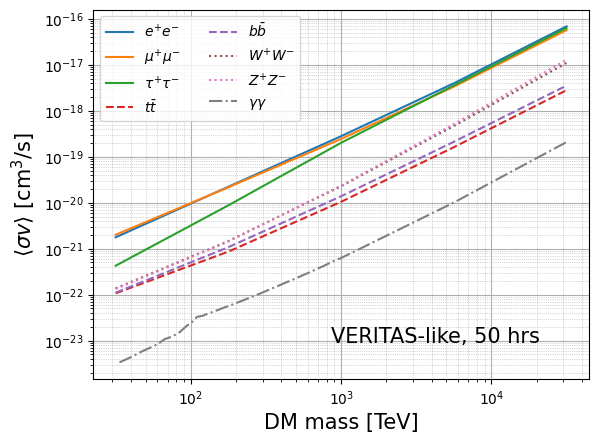

In [23]:
chan = ["ee", "uu", "tt", "ttbar", "bbar", "WW", "ZZ", "gamma"]
chan_lab = [r"$e^{+}e^{-}$", r"$\mu^{+}\mu^{-}$", r"$\tau^{+}\tau^{-}$",
            r"$t\bar{t}$", r"$b\bar{b}$",
            r"$W^{+}W^{-}$", r"$Z^{+}Z^{-}$", r"$\gamma\gamma$"]

ls = ["-", "-", "-", "--", "--", ":",":", "-."]

for c, cl, l in zip(chan, chan_lab, ls):
    filename = "vts_like_"+c
    Likelihood.plotExpULcurve(filename=filename, label=cl, units="TeV", ls=l, mean_only=True)
plt.legend(loc=2, ncol=2)

ax = plt.gca()
plt.text(0.9, 0.1, "VERITAS-like, 50 hrs", fontsize=15, ha="right", transform=ax.transAxes)
#plt.text(0.9, 0.2, "95% upper limits", fontsize=15, ha="right", transform=ax.transAxes)
plt.xlabel("DM mass [TeV]", fontsize=15)
#plt.savefig("VERITAS_ULs.pdf")

In [ ]:
mass = np.logspace(4.5, 7.5, 5)


In [ ]:
print("a")

In [ ]:
N_on_vts

In [ ]:
N_off_vts

In [ ]:
channel="ttbar"
package="VEGAS"
filename = "vts_like_{}_jsys".format(channel)
Likelihood.calcULSysError(dwarf, channel, package=package, irf = irf, mass=mass, method=2, averagedIRF=True, DM_spectra="HDM",
                              jArray=True,  addTheta=False, version="all", ext=False, multi=False,
                              useBias=True, verbosity=2, runs=1000, filename=filename, test=True, seed=9, statistic="simple",
                              N_on=N_off_vts*alpha, alpha = alpha, N_off = N_off_vts)

In [ ]:
Likelihood.plotExpULcurve(filename="vts_like_ttbar_jsys", label="VERITAS-like", which = [68, 95], units="TeV")
Likelihood.plotExpULcurve(filename="vts_like_ttbar_sys", label="VERITAS-like", which = [68, 95], units="TeV")
#Likelihood.plotExpULcurve(filename="CTA_like_ttbar_sys", label="CTA-North", which = [68, 95], units="TeV")
#Likelihood.plotExpULcurve(filename="CTA_like_ttbar_jsys", label="CTA-North", which = [68, 95], units="TeV")
#Likelihood.plotExpULcurve(filename="hawc_like_ttbar_jsys", label="HAWC-like", which = [68, 95], units="TeV")

plt.legend(loc=2, fontsize=12)
ax = plt.gca()
plt.text(0.9, 0.1, r"$t\bar{t}$ annihilation channel", fontsize=15, ha="right", transform=ax.transAxes)
plt.xlabel("DM mass [TeV]", fontsize=15)
#plt.savefig("stat_err.pdf")

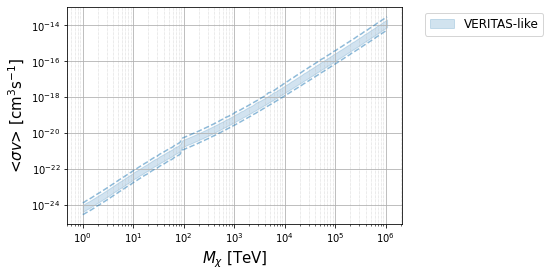

In [7]:
Likelihood.plotExpULcurve(filename="vts_like_gamma_new", label="VERITAS-like", units="TeV")

In [ ]:
Likelihood.plotExpULcurve(filename="vts_like_ttbar_sys", label="VERITAS-like", which = [68, 95], units="TeV")
Likelihood.plotExpULcurve(filename="CTA_like_ttbar_sys", label="CTA-North", which = [68, 95], units="TeV")
Likelihood.plotExpULcurve(filename="hawc_like_ttbar_sys", label="HAWC-like", which = [68, 95], units="TeV")

plt.legend(loc=2, fontsize=12)
ax = plt.gca()
plt.text(0.9, 0.1, r"$t\bar{t}$ annihilation channel", fontsize=15, ha="right", transform=ax.transAxes)
plt.xlabel(r"$M_{\chi}$ [TeV]", fontsize=15)
#plt.savefig("stat_err.pdf")

In [ ]:
Likelihood.plotExpULcurve(filename="vts_like_ttbar_jsys", label="VERITAS-like", which = [68, 95], units="TeV")
Likelihood.plotExpULcurve(filename="CTA_like_ttbar_jsys", label="CTA-North", which = [68, 95], units="TeV")
#Likelihood.plotExpULcurve(filename="hawc_like_ttbar_sys", label="HAWC-like", which = [68, 95], units="TeV")

plt.legend(loc=2, fontsize=12)
ax = plt.gca()
plt.text(0.9, 0.1, r"$t\bar{t}$ annihilation channel", fontsize=15, ha="right", transform=ax.transAxes)
plt.xlabel("DM mass [TeV]", fontsize=15)
#plt.savefig("stat_err.pdf")

In [ ]:
plt.style.use("default")

In [ ]:
Likelihood.plotExpULcurve(filename="vts_like_ttbar_sys", label="VERITAS-like (50 hrs)", which = [68, 95], units="TeV")
Likelihood.plotExpULcurve(filename="CTA_like_ttbar_sys", label="CTA-North (50 hrs)", which = [68, 95], units="TeV")
Likelihood.plotExpULcurve(filename="hawc_like_ttbar_sys", label="HAWC-like (507 days)", which = [68, 95], units="TeV")

plt.legend(loc=2, fontsize=12)
ax = plt.gca()
plt.text(0.9, 0.1, r"$t\bar{t}$ annihilation channel", fontsize=15, ha="right", transform=ax.transAxes)
plt.xlabel(r"$M_{\chi}$ [TeV]", fontsize=15)
plt.savefig("stat_err.pdf")

In [ ]:
x = np.load(const.OUTPUT_DIR+"vts_like_ttbar_jsys.npy", allow_pickle=True).item()

In [ ]:
y = []
for m in x.keys():
    y.append(np.percentile((10**np.asarray(x[m]))/10**np.average(x[m]), 84))
    y.append(1/np.percentile((10**np.asarray(x[m]))/10**np.average(x[m]), 16))

np.average(y)

In [ ]:
plt.hist(np.log10((10**np.asarray(x[m])-10**np.average(x[m]))/10**np.average(x[m])), bins=20)

In [ ]:
Likelihood.plotExpULcurve(filename="vts_like_ttbar_jsys", label="VERITAS-like (50 hrs)", which = [68, 95], units="TeV")
Likelihood.plotExpULcurve(filename="CTA_like_ttbar_jsys", label="CTA-North (50 hrs)", which = [68, 95], units="TeV")
Likelihood.plotExpULcurve(filename="hawc_like_ttbar_jsys", label="HAWC-like (507 days)", which = [68, 95], units="TeV")

plt.legend(loc=2, fontsize=12)
ax = plt.gca()
plt.text(0.9, 0.1, r"$t\bar{t}$ annihilation channel", fontsize=15, ha="right", transform=ax.transAxes)
plt.xlabel(r"$M_{\chi}$ [TeV]", fontsize=15)
plt.savefig("sys_err.pdf")

In [ ]:
vrel = 1.e-3
TeV2cm3s = 1.1673299710900705e-23

### s-wave Unitarity limit ###
# This is equation (10) of [Griest, Kamionkowski 1990], with J=0 for s-wave
def slim(m):
    "m [TeV]"
    return TeV2cm3s*(4.*np.pi)/(m**2.*vrel)

# Add in the finite size, which is (5) in https://arxiv.org/pdf/2203.06029.pdf, or (16) in Kamionkowski and Griest (but they expand in the last step)

### Composite Unitarity limit ###
# This is equation (16) of [Griest, Kamionkowski 1990], but without the approximation that Jmax >> 1 as they use in the final step
def Rlim(m, Rinv):
    "m [TeV], Rinv [TeV]"
    R = 1./Rinv
    return TeV2cm3s*(4.*np.pi)/(m**2.*vrel)*(1.+m*vrel*R)**2.

In [ ]:
plt.style.use("default")

In [ ]:

# Fonts
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'CMU Serif'
mpl.rcParams['font.sans-serif'] = 'CMU Sans Serif, DejaVu Sans, Bitstream Vera Sans, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif'
mpl.rcParams['text.usetex'] = True


In [ ]:
#rescale=1.1
#plot_h = 10/rescale
#plot_w = 8/rescale
fig, ax = plt.subplots(1)

plt.xlabel(r'$M_{\chi}$ [TeV]',fontsize=28)
plt.ylabel(r'$\langle \sigma v \rangle$ [cm$^3$/s]',fontsize=28)

mpl.rcParams['lines.dashed_pattern'] = 7.5, 7.5
plt.axvline(340.,ls='--',c='gray',lw=1.)
plt.fill_between([340.,4.e4],[1.e-28,1.e-28],[1.e-16,1.e-16],color=(0.8,0.8,0.8),alpha=0.3)

plt.plot([10.,340.],[2.4e-26,2.4e-26],c='red',lw=2.)

mpl.rcParams['lines.dotted_pattern'] = 1.1, 2.5
mv=np.logspace(1.,np.log10(4.e4),100)
cv="black"
plt.plot(mv,Rlim(mv,1.e-3),ls=':',c=cv,lw=1.5,zorder=2)
plt.plot(mv,Rlim(mv,1.e-2),ls=':',c=cv,lw=1.5,zorder=2)
plt.plot(mv,Rlim(mv,1.e-1),ls=':',c=cv,lw=1.5,zorder=2)
plt.plot(mv,Rlim(mv,1.),ls=':',c=cv,lw=1.5,zorder=2)
plt.plot([10.,4.e4],[slim(10.),slim(4.e4)],c='black',lw=2.,zorder=2)

plt.xscale('log')
plt.yscale('log')
plt.xlim([10.,4.e4])
#plt.ylim([1.e-28,1.e-17])

# Restore y ticks
locmaj = mpl.ticker.LogLocator(base=10, numticks=1000)
ax.yaxis.set_major_locator(locmaj)

locmin = mpl.ticker.LogLocator(base=10.0, subs=np.linspace(0, 1.0, 11)[1:-1], numticks=1000)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

# Text
#plt.text(1.15e1,1.5e-18,r'Unitarity Limits',fontsize=13)

plt.text(2.5e2,6.e-27,r'Thermal $\langle \sigma v \rangle$',fontsize=13, ha="right")
plt.text(400,3.e-28,r'Non-Thermal Relic',fontsize=13,color=(0.3,0.3,0.3))
plt.text(1.1e3, 3e-26,r'Partial-Wave Unitarity',fontsize=13,color='black',rotation=340, ha="right")
plt.text(1.1e3,4e-20,r'Composite Unitarity',fontsize=13,color=cv, ha="right")

plt.text(3e4,3.5e-20,r'$R=(1~{\rm GeV})^{-1}$',fontsize=13,color=cv, ha="right")
plt.text(3e4,3.5e-22,r'$R=(10~{\rm GeV})^{-1}$',fontsize=13,color=cv, ha="right")
plt.text(3e4,3.5e-24,r'$R=(100~{\rm GeV})^{-1}$',fontsize=13,color=cv, ha="right")
plt.text(3e4,3.5e-26,r'$R=(1~{\rm TeV})^{-1}$',fontsize=13,color=cv, ha="right")

#plt.tight_layout()
#plt.legend()
c = "ttbar"
filename = "vts_like_"+c
Likelihood.plotExpULcurve(filename=filename, label="VERITAS-like (50 hrs)", units="TeV",  mean_only=True)
filename = "cta_"+c
Likelihood.plotExpULcurve(filename=filename, label="CTA-North (50 hrs)", units="TeV", mean_only=True)
filename = "hawc_like_"+c
Likelihood.plotExpULcurve(filename=filename, label="HAWC-like (507 days)", units="TeV", mean_only=True)
#plt.xlabel(r'$M_{\chi}$ [TeV]',fontsize=15)
plt.xlim(25, )
plt.ylim(1e-28, 1e-16)
plt.legend(loc=2, fontsize=10)
plt.savefig('./HighMass-Limits.pdf')
plt.show()

In [ ]:
chan = ["ee", "uu", "tt", "ttbar", "bbar", "WW", "ZZ", "gamma"]
chan_lab = [r"$e^{+}e^{-}$", r"$\mu^{+}\mu^{-}$", r"$\tau^{+}\tau^{-}$",
            r"$t\bar{t}$", r"$b\bar{b}$",
            r"$W^{+}W^{-}$", r"$Z^{+}Z^{-}$", r"$\gamma\gamma$"]

ls = ["-", "-", "-", "--", "--", ":",":", "-."]

for c, cl, l in zip(chan, chan_lab, ls):
    filename = "vts_like_"+c
    Likelihood.plotExpULcurve(filename=filename, label=cl, units="TeV", ls=l, mean_only=True)
plt.legend(loc=2, ncol=2)

ax = plt.gca()
plt.text(0.9, 0.1, "VERITAS-like, 50 hrs", fontsize=15, ha="right", transform=ax.transAxes)
#plt.text(0.9, 0.2, "95% upper limits", fontsize=15, ha="right", transform=ax.transAxes)
plt.xlabel(r"$M_{\chi}$ [TeV]", fontsize=15)
plt.ylim(1e-26, 2e-15)
plt.savefig("VERITAS_ULs.pdf")

In [ ]:
chan = ["ee", "uu", "tt", "ttbar", "bbar", "WW", "ZZ", "gamma"]
chan_lab = [r"$e^{+}e^{-}$", r"$\mu^{+}\mu^{-}$", r"$\tau^{+}\tau^{-}$",
            r"$t\bar{t}$", r"$b\bar{b}$",
            r"$W^{+}W^{-}$", r"$Z^{+}Z^{-}$", r"$\gamma\gamma$"]

ls = ["-", "-", "-", "--", "--", ":",":", "-."]

for c, cl, l in zip(chan, chan_lab, ls):
    filename = "cta_like_"+c
    Likelihood.plotExpULcurve(filename=filename, label=cl, units="TeV", ls=l, mean_only=True)
plt.legend(loc=2, ncol=2)

ax = plt.gca()
plt.text(0.9, 0.1, "CTA-North, 50 hrs", fontsize=15, ha="right", transform=ax.transAxes)
#plt.text(0.9, 0.2, "95% upper limits", fontsize=15, ha="right", transform=ax.transAxes)
plt.xlabel(r"$M_{\chi}$ [TeV]", fontsize=15)
plt.ylim(1e-26, 2e-15)
plt.savefig("CTA_ULs.pdf")

In [ ]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [ ]:
chan = ["ee", "uu", "tt", "ttbar", "bbar", "WW", "ZZ", "gamma"]
chan_lab = [r"$e^{+}e^{-}$", r"$\mu^{+}\mu^{-}$", r"$\tau^{+}\tau^{-}$",
            r"$t\bar{t}$", r"$b\bar{b}$",
            r"$W^{+}W^{-}$", r"$Z^{+}Z^{-}$", r"$\gamma\gamma$"]

ls = ["-", "-", "-", "--", "--", ":",":", "-."]

for c, cl, l in zip(chan, chan_lab, ls):
    filename = "hawc_like_"+c+"_v2"
    Likelihood.plotExpULcurve(filename=filename, label=cl, units="TeV", ls=l, mean_only=True)
plt.legend(loc=2, ncol=2)

ax = plt.gca()
plt.text(0.9, 0.1, "HAWC-like, 507 days", fontsize=15, ha="right", transform=ax.transAxes)
#plt.text(0.9, 0.2, "95% upper limits", fontsize=15, ha="right", transform=ax.transAxes)
plt.xlabel(r"$M_{\chi}$ [TeV]", fontsize=15)
plt.ylim(1e-26, 2e-15)
#plt.legend(fontsize=13, loc=2, ncol=2)
plt.savefig("HAWC_ULs.pdf")